In [ ]:
!pip install PyMuPDF 
!pip install tqdm  
!pip install accelerate
!pip install bitsandbytes 
!pip install flash-attn --no-build-isolation 

In [2]:
import fitz
from tqdm.auto import tqdm 


def text_formatter(text:str)->str:
    clean_text = text.replace("\n" , " ").strip()
    return clean_text
def open_read_pdf(pdf_path:str) -> str : 
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_num , page in tqdm(enumerate(doc)) : 
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number":page_num-20,
                                "page_char_count":len(text),
                                "page_word_count":len(text.split(" ")),
                                "page_sentence_count_raw":len(text.split('. ')),
                                "page_token_count":len(text)/4 ,# 1 token ~ 4 chars
                                "text":text})
        
    return pages_and_texts    

In [3]:
pdf_path="Guyton and Hall Textbook of Medical Physiology ( PDFDrive ).pdf"

pages_and_texts = open_read_pdf(pdf_path=pdf_path)
pages_and_texts[21]

0it [00:00, ?it/s]

{'page_number': 1,
 'page_char_count': 277,
 'page_word_count': 50,
 'page_sentence_count_raw': 1,
 'page_token_count': 69.25,
 'text': 'U n i t I Introduction to Physiology: The Cell  and General Physiology \t 1.\t Functional Organization of the Human  Body and Control of the “Internal  Environment” \t 2.\t The Cell and Its Functions \t 3.\t Genetic Control of Protein Synthesis, Cell  Function, and Cell Reproduction'}

In [4]:
pages_and_texts[23]

{'page_number': 3,
 'page_char_count': 4131,
 'page_word_count': 716,
 'page_sentence_count_raw': 29,
 'page_token_count': 1032.75,
 'text': 'U n i t  I 3 Functional Organization of the Human Body  and\xa0Control of the “Internal Environment” chapter 1 The goal of physiology is  to explain the physical and  chemical factors that are  responsible for the origin,  development, and progres- sion of life. Each type of life,  from the simple virus to  the largest tree or the complicated human being, has its  own functional characteristics. Therefore, the vast field of  physiology can be divided into viral physiology, bacterial  physiology, cellular physiology, plant physiology, human  physiology, and many more subdivisions. Human Physiology.\u2002 In human physiology, we  attempt to explain the specific characteristics and mech- anisms of the human body that make it a living being.  The very fact that we remain alive is the result of com- plex control systems, for hunger makes us seek food 

In [5]:
import pandas as pd 
df  = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-20,0,1,1,0.00,
1,-19,84,9,1,21.00,Guyton and Hall Textbook of Medical Physiolog...
2,-18,34,5,1,8.50,This page intentionally left blank
3,-17,275,51,4,68.75,Guyton and Hall Textbook of Medical Physiolog...
4,-16,2803,445,39,700.75,1600 John F. Kennedy Blvd. Ste 1800 Philadelph...


In [6]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000
mean,535.500000,4623.241906,777.054856,26.403777,1155.810477
std,321.151055,1650.426619,276.955539,10.270058,412.606655
min,-20.000000,0.000000,1.000000,1.000000,0.000000
25%,257.750000,4069.000000,684.000000,22.000000,1017.250000
50%,535.500000,4935.500000,841.500000,28.000000,1233.875000
75%,813.250000,5760.000000,960.250000,33.000000,1440.000000
max,1091.000000,7300.000000,1248.000000,59.000000,1825.000000


##  Chunking Strategies

### 1. Fixed size Chunking

In [7]:
def chunk_text(text:str,chunk_size:int=500) -> list:
    chunks = []
    current_chunk = ''
    words = text.split()
    for word in words : 
        if len(current_chunk) + len(word) + 1 <= chunk_size : 
            current_chunk += (word + " ")
        else : 
            chunks.append(current_chunk)
            current_chunk = word + " "
    ## adding the last chunk if it is not empty    
    if current_chunk : 
        chunks.append(current_chunk.strip())
    return chunks     


def chunks_pdf_pages(pages_and_texts:list,chunk_size:int=500)->list[dict]:
    all_chunks = []
    for page in pages_and_texts : 
        page_number = page["page_number"]
        page_text = page["text"]
        
        chunks = chunk_text(page_text,chunk_size=chunk_size)
        for i,chunk in enumerate(chunks) : 
            all_chunks.append({
                "page_number":page_number,
                "chunk_index" : i,
                "chunk_char_count":  len(chunk),
                "chunk_word_count" : len(chunk.split()),
                "chunk_token_count": len(chunk)/4,
                "chunk_text":chunk
            })
    return all_chunks

In [8]:
chunked_pages = chunks_pdf_pages(pages_and_texts,chunk_size=500)
print(f"Total chunks: {len(chunked_pages)}")
print(f"Chunk sample (page {chunked_pages[200]["page_number"]}) : {chunked_pages[200]["chunk_text"][:200]}")

Total chunks: 10786
Chunk sample (page 14) : 2-4. The space inside the tubules and vesicles is filled with endoplasmic matrix, a watery medium that is different from the fluid in the cytosol outside the endoplasmic reticulum. Electron micrograph


In [9]:
import random,textwrap 
# -------------------------Sampling & Pretty Printing--------------------------
def _scattered_indices(n:int,k:int,jitter_frac:float=0.08) -> list[int] : 
    if k<=0 :
        return []
    if k==1 : 
        return [random.randrange(n)]
    anchors = [int(round(i*(n-1)/(k-1))) for i in range(k)]
    out,seen = [],set()
    radius = max(1,int(n*jitter_frac))
    for a in anchors : 
        lo,hi = max(0,a-radius) , min(n-1,a+radius)
        j = random.randint(lo,hi)
        if j not in seen : 
            out.append(j);seen.add(j)
    while len(out)<k : 
        r = random.randrange(n)
        if r not in seen :
            out.append(r),seen.add(r)
    return out

def _draw_boxed_chunk(c:dict,wrap_at:int=96) -> str : 
    header = (
        f"Chunk p{c['page_number']} -- idx {c['chunk_index']}  |  "
        f"Chars {c['chunk_char_count']} -- words {c['chunk_word_count']} -- ~tokens {c['chunk_token_count']} "
    )
    
    wrapped_lines = textwrap.wrap(
        c['chunk_text'],width=wrap_at,break_long_words=False,replace_whitespace=False
    )
    context_width = max([0,*map(len,wrapped_lines)])
    box_width = max(len(header),context_width+2)
    
    top    = "=" + (box_width+4)*"=" + "="
    hline  = "||" + header.ljust(box_width) + "  ||"
    sep    = "||-" + "-"*box_width + "-||"
    body   = "\n".join("||" + line.ljust(box_width--2)+'||' for line in wrapped_lines) or \
        ("||"+"".ljust(box_width-2) + "||")
    bottom = "=" + (box_width+4)*"=" + "="
    
    return "\n".join([top,hline,sep,body,bottom])

def show_random_chunks(pages_and_texts,chunk_size:int=500,k:int=5,seed:int | None = 42) : 
    if seed is not None : 
        random.seed(seed)
    all_chunks = chunks_pdf_pages(pages_and_texts,chunk_size)
    if not all_chunks : 
        print(f"No chunks are available.")
        return
    idxs = _scattered_indices(len(all_chunks),k)
    print(f"Showing {len(idxs)} scattered random chunks ou of {len(all_chunks)} in total:\n ")
    for i ,idx in enumerate(idxs,1):
        print(f"#{i}")
        print(_draw_boxed_chunk(all_chunks[idx]))
        print()

In [10]:
assert 'pages_and_texts' in globals() , "Run : pages_and_texts = open_and_read_pdf(odf_path) first."
show_random_chunks(pages_and_texts,chunk_size=500,k=2,seed=42)

Showing 2 scattered random chunks ou of 10786 in total:
 
#1
||Chunk p64 -- idx 2  |  Chars 498 -- words 84 -- ~tokens 124.5                                       ||
||----------------------------------------------------------------------------------------------------||
||have a calcium pump similar to the sodium pump, and calcium serves along with (or instead of)       ||
||sodium in some cells to cause most of the action potential. Like the sodium pump, the calcium       ||
||pump transports calcium ions from the interior to the exterior of the cell membrane (or into the    ||
||endoplas- mic reticulum of the cell), creating a calcium ion gradient of about 10,000-fold. This    ||
||leaves an internal cell concentration of calcium ions of about 10−7 molar, in contrast to an        ||
||external concentration                                                                              ||

#2
||Chunk p1032 -- idx 10  |  Chars 500 -- words 86 -- ~tokens 125.0                             

### 2. Semantic Chunking 

In [11]:
from sentence_transformers import SentenceTransformer 
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
nltk.download('punkt',quiet=True) 
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DHIA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
semantic_model = SentenceTransformer("all-MiniLM-L6-V2")

In [13]:
def semantic_chunk_text(text:str,similarity_threshold:float=0.8,max_tokens:int=500)->list:
    sentences = nltk.sent_tokenize(text)
    if not sentences : 
        return []
    embeddings = semantic_model.encode(sentences) ## break the page into sentences
    chunks = []
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]
    for i in range(1,len(sentences)) : 
        sim = cosine_similarity([current_embedding],[embeddings[i]])[0][0]
        chunk_token_count = len(" ".join(current_chunk)) // 4 
        if sim >= similarity_threshold and chunk_token_count <max_tokens : 
            current_chunk.append(sentences[i])
            current_embedding = np.mean([current_embedding,embeddings[i]],axis=0)
        else : 
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]
    if current_chunk : 
        chunks.append(" ".join(current_chunk))
    return chunks

from tqdm.auto import tqdm 
def semantic_chunk_pdf_pages(pages_and_texts:list,
                             similarity_threshold:float=0.8,
                             max_tokens:int=500
                             )->list[dict] : 
    all_chunks = []
    for page in tqdm(pages_and_texts,desc="Semantic chunking pages") : 
        page_number = page["page_number"]
        page_text = page["text"]
        
        chunks = semantic_chunk_text(page_text,similarity_threshold,max_tokens)
        for i,chunk in enumerate(chunks) : 
            all_chunks.append({
                "page_number":page_number,
                "chunk_index" : i,
                "chunk_char_count":  len(chunk),
                "chunk_word_count" : len(chunk.split()),
                "chunk_token_count": len(chunk)/4,
                "chunk_text":chunk
            })
    return all_chunks

In [14]:
chunked_pages = semantic_chunk_pdf_pages(pages_and_texts,similarity_threshold=0.8,max_tokens=500)
print(f"Total chunks: {len(chunked_pages)}")
print(f"Chunk sample (page {chunked_pages[200]["page_number"]}) : {chunked_pages[200]["chunk_text"][:200]}")

Semantic chunking pages:   0%|          | 0/1112 [00:00<?, ?it/s]

Total chunks: 31525
Chunk sample (page 5) : An important segment of the nervous system is called  the autonomic system.


In [15]:
import random,textwrap 
# -------------------------Sampling & Pretty Printing--------------------------
def _scattered_indices(n:int,k:int,jitter_frac:float=0.08) -> list[int] : 
    if k<=0 :
        return []
    if k==1 : 
        return [random.randrange(n)]
    anchors = [int(round(i*(n-1)/(k-1))) for i in range(k)]
    out,seen = [],set()
    radius = max(1,int(n*jitter_frac))
    for a in anchors : 
        lo,hi = max(0,a-radius) , min(n-1,a+radius)
        j = random.randint(lo,hi)
        if j not in seen : 
            out.append(j);seen.add(j)
    while len(out)<k : 
        r = random.randrange(n)
        if r not in seen :
            out.append(r),seen.add(r)
    return out

def _draw_boxed_chunk(c:dict,wrap_at:int=96) -> str : 
    header = (
        f"Chunk p{c['page_number']} -- idx {c['chunk_index']}  |  "
        f"Chars {c['chunk_char_count']} -- words {c['chunk_word_count']} -- ~tokens {c['chunk_token_count']} "
    )
    
    wrapped_lines = textwrap.wrap(
        c['chunk_text'],width=wrap_at,break_long_words=False,replace_whitespace=False
    )
    context_width = max([0,*map(len,wrapped_lines)])
    box_width = max(len(header),context_width+2)
    
    top    = "=" + (box_width+4)*"=" + "="
    hline  = "||" + header.ljust(box_width) + "  ||"
    sep    = "||-" + "-"*box_width + "-||"
    body   = "\n".join("||" + line.ljust(box_width--2)+'||' for line in wrapped_lines) or \
        ("||"+"".ljust(box_width-2) + "||")
    bottom = "=" + (box_width+4)*"=" + "="
    
    return "\n".join([top,hline,sep,body,bottom])

def show_random_Semantic_chunks(pages_and_texts,similarity_threshold:float,max_tokens:int,k:int,seed:int | None = 42) : 
    if seed is not None : 
        random.seed(seed)
    all_chunks = semantic_chunk_pdf_pages(pages_and_texts,similarity_threshold,max_tokens)
    if not all_chunks : 
        print(f"No chunks are available.")
        return
    idxs = _scattered_indices(len(all_chunks),k)
    print(f"Showing {len(idxs)} scattered random chunks ou of {len(all_chunks)} in total:\n ")
    for i ,idx in enumerate(idxs,1):
        print(f"#{i}")
        print(_draw_boxed_chunk(all_chunks[idx]))
        print()

In [16]:
show_random_Semantic_chunks(pages_and_texts,similarity_threshold=0.8,max_tokens=500,k=3,seed=42)

Semantic chunking pages:   0%|          | 0/1112 [00:00<?, ?it/s]

Showing 3 scattered random chunks ou of 31525 in total:
 
#1
||Chunk p14 -- idx 24  |  Chars 227 -- words 34 -- ~tokens 56.75                                      ||
||----------------------------------------------------------------------------------------------------||
||(3) Many of the carbohydrates act as  receptor substances for binding hormones, such as insulin;    ||
||when bound, this combination activates attached inter- nal proteins that, in turn, activate a       ||
||cascade of intracel- lular enzymes.                                                                 ||

#2
||Chunk p473 -- idx 21  |  Chars 135 -- words 23 -- ~tokens 33.75                             ||
||--------------------------------------------------------------------------------------------||
||Both of these are released in the  lung tissues by mast cells during allergic reactions,    ||
||especially  those caused by pollen in the air.                                              ||

#3
||Chunk p1038 -- i

### 3.Recursive Chunking

In [17]:
def recursive_chunk_pages(text:str, max_chunk_size:int=1000,min_chunk_size:int=100) -> list : 
    def split_chunk(chunk:str)->list : 
        if len(chunk)<=max_chunk_size : 
            return [chunk]
        sections = chunk.split("\n\n") ## splitting by double new lines
        if len(sections)>1 : 
            result = []
            for section in sections : 
                if section.strip() : 
                    result.extend(split_chunk(section.strip()))
            return result
        
        sections = chunk.split("\n") ## splitting by single new line
        if len(sections)>1 : 
            result = []
            for section in sections : 
                if section.strip() : 
                    result.extend(split_chunk(section.strip()))
            return result
        
        ## split to sentences 
        sentences = nltk.sent_tokenize(chunk)
        chunks,current_chunk,current_size = [],[],0
        for sentence in sentences :
            if current_size + len(sentence) > max_chunk_size : 
                if current_chunk : 
                    chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_size = len(sentence)
            else : 
                current_chunk.append(sentence)
                current_size += len(sentence)
        if current_chunk : 
            chunks.append(" ".join(current_chunk))
        return chunks
    return split_chunk(text)

def Recursive_chunk_pdf_pages(pages_and_texts:list,max_chunk_size:int,min_chunk_size:int)->list[dict] : 
    all_chunks = []
    for page in tqdm(pages_and_texts,desc="Recursive chunking pages") : 
        page_number = page["page_number"]
        page_text = page["text"]
        
        chunks = recursive_chunk_pages(page_text,max_chunk_size,min_chunk_size)
        for i,chunk in enumerate(chunks) : 
            all_chunks.append({
                "page_number":page_number,
                "chunk_index" : i,
                "chunk_char_count":  len(chunk),
                "chunk_word_count" : len(chunk.split()),
                "chunk_token_count": len(chunk)/4,
                "chunk_text":chunk
            })
    return all_chunks

In [18]:
recursive_chunks = Recursive_chunk_pdf_pages(pages_and_texts,max_chunk_size=1000,min_chunk_size=100) 
print(f"Total chunks: {len(recursive_chunks)}")
print(f"Chunk sample (page {recursive_chunks[200]["page_number"]}) : {recursive_chunks[200]["chunk_text"]}")

Recursive chunking pages:   0%|          | 0/1112 [00:00<?, ?it/s]

Total chunks: 6117
Chunk sample (page 36) : Because there are more than 30,000 different genes  in each human cell, the large number of ways in which  genetic activity can be controlled is not surprising. The  gene control systems are especially important for control- ling intracellular concentrations of amino acids, amino  acid derivatives, and intermediate substrates and ­products  of carbohydrate, lipid, and protein metabolism. Control of Intracellular Function   by Enzyme Regulation In addition to control of cell function by genetic regula- tion, some cell activities are controlled by intracellular  inhibitors or activators that act directly on specific intra- cellular enzymes. Thus, enzyme regulation represents a  second category of mechanisms by which cellular bio- chemical functions can be controlled. Enzyme Inhibition. Some chemical substances formed  in the cell have direct feedback effects in inhibiting the spe- cific enzyme systems that synthesize them.


In [19]:
import random,textwrap 
# -------------------------Sampling & Pretty Printing--------------------------
def _scattered_indices(n:int,k:int,jitter_frac:float=0.08) -> list[int] : 
    if k<=0 :
        return []
    if k==1 : 
        return [random.randrange(n)]
    anchors = [int(round(i*(n-1)/(k-1))) for i in range(k)]
    out,seen = [],set()
    radius = max(1,int(n*jitter_frac))
    for a in anchors : 
        lo,hi = max(0,a-radius) , min(n-1,a+radius)
        j = random.randint(lo,hi)
        if j not in seen : 
            out.append(j);seen.add(j)
    while len(out)<k : 
        r = random.randrange(n)
        if r not in seen :
            out.append(r),seen.add(r)
    return out

def _draw_boxed_chunk(c:dict,wrap_at:int=96) -> str : 
    header = (
        f"Chunk p{c['page_number']} -- idx {c['chunk_index']}  |  "
        f"Chars {c['chunk_char_count']} -- words {c['chunk_word_count']} -- ~tokens {c['chunk_token_count']} "
    )
    
    wrapped_lines = textwrap.wrap(
        c['chunk_text'],width=wrap_at,break_long_words=False,replace_whitespace=False
    )
    context_width = max([0,*map(len,wrapped_lines)])
    box_width = max(len(header),context_width+2)
    
    top    = "=" + (box_width+4)*"=" + "="
    hline  = "||" + header.ljust(box_width) + "  ||"
    sep    = "||-" + "-"*box_width + "-||"
    body   = "\n".join("||" + line.ljust(box_width--2)+'||' for line in wrapped_lines) or \
        ("||"+"".ljust(box_width-2) + "||")
    bottom = "=" + (box_width+4)*"=" + "="
    
    return "\n".join([top,hline,sep,body,bottom])

def show_random_Semantic_chunks(pages_and_texts,max_chunk_size:int,min_chunk_size:int,k:int,seed:int | None = 42) : 
    if seed is not None : 
        random.seed(seed)
    all_chunks = Recursive_chunk_pdf_pages(pages_and_texts,max_chunk_size=1000,min_chunk_size=100)
    if not all_chunks : 
        print(f"No chunks are available.")
        return
    idxs = _scattered_indices(len(all_chunks),k)
    print(f"Showing {len(idxs)} scattered random chunks ou of {len(all_chunks)} in total:\n ")
    for i ,idx in enumerate(idxs,1):
        print(f"#{i}")
        print(_draw_boxed_chunk(all_chunks[idx]))
        print()

In [20]:
show_random_Semantic_chunks(pages_and_texts,max_chunk_size=1000,min_chunk_size=100,k=2,seed=42)

Recursive chunking pages:   0%|          | 0/1112 [00:00<?, ?it/s]

Showing 2 scattered random chunks ou of 6117 in total:
 
#1
||Chunk p60 -- idx 2  |  Chars 910 -- words 152 -- ~tokens 227.5                                      ||
||----------------------------------------------------------------------------------------------------||
||Using this value in the Goldman equation gives  a potential inside the membrane of −86              ||
||millivolts, which is  near the potassium potential shown in the figure. Contribution of the         ||
||Na+-K+ Pump. In Figure 5-5C,  the Na+-K+ pump is shown to provide an additional contri- bution      ||
||to the resting potential. In this figure, there is con- tinuous pumping of three sodium ions to     ||
||the outside for  each two potassium ions pumped to the inside of the mem- brane. The fact that      ||
||more sodium ions are being pumped  to the outside than potassium to the inside causes con-          ||
||tinual loss of positive charges from inside the membrane;  this creates an additional degree of   

### 4. LLM-based Chunking

In [ ]:
import requests
from typing import List, Dict

HF_API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct"
HF_HEADERS = {"Authorization": " ## Access Token ##"}  # paste your token here

def llm_based_chunking(text: str, chunk_size: int = 1000) -> List[Dict]:
    """
    Using Hugging Face hosted LLM to find semantically coherent chunk boundaries
    given a target chunk size.
    """
    
    def get_chunk_boundary(text_segment:str) -> int : 
        prompt = f"""
            Analyze the following text and identify the best point to split it 
            into two semantically coherent parts.
            The split should occur near {chunk_size} characters 
            Text:
            \"\"\"{text_segment}"
            Return only the integer index (character position) within this text
            where the split should occur.Do not return any explanation.
            """
            
        payload = {"inputs": prompt, "parameters": {"max_new_tokens": 20}}
        response = requests.post(HF_API_URL, headers=HF_HEADERS, json=payload)
        result = response.json()

        if isinstance(result, list) and len(result) > 0 and "generated_text" in result[0]:
            split_str = result[0]["generated_text"].strip()
        else:
            split_str = str(chunk_size)

        try:
            split_point = int(split_str)
        except ValueError:
            split_point = chunk_size

        return split_point
    chunks = []
    remaining_text = text 
    while len(remaining_text) > chunk_size : 
        text_window = remaining_text[:chunk_size]
        split_point  = get_chunk_boundary(text_window)
        if split_point < 100 or split_point> len(text_window)-100 : 
            split_point = chunk_size
        chunks.append(remaining_text[:split_point].strip())
        remaining_text = remaining_text[split_point:].strip()
    if remaining_text:
        chunks.append(remaining_text)
    return chunks

In [22]:
def llm_based_chunk_pdf_pages(pages_and_texts:List[Dict],chunk_size:int=1000) -> List[Dict] : 
    all_chunks = []
    for page in tqdm(pages_and_texts,desc="LLM based chunking pages") : 
        page_number = page["page_number"]
        page_text = page["text"]
        
        chunks = llm_based_chunking(page_text,chunk_size)
        for i,chunk in enumerate(chunks) : 
            all_chunks.append({
                "page_number":page_number,
                "chunk_index" : i, 
                "chunk_char_count":  len(chunk),
                "chunk_word_count" : len(chunk.split()),
                "chunk_token_count": len(chunk)/4,
                "chunk_text":chunk
            })
    return all_chunks


In [23]:
llm_chunked_pages = llm_based_chunk_pdf_pages(pages_and_texts,1000)

LLM based chunking pages:   0%|          | 0/1112 [00:00<?, ?it/s]

In [24]:
print(f"Total chunks: {len(llm_chunked_pages)}")
print(f"Chunk sample (page {llm_chunked_pages[2000]["page_number"]}) : {llm_chunked_pages[2000]["chunk_text"]}")

Total chunks: 5733
Chunk sample (page 388) : e fact that the pK of this system is about  6.8. Under normal conditions, the urine is slightly acidic,  and the urine pH is near the pK of the phosphate buffer sys- tem. Therefore, in the tubules, the phosphate buffer system  normally functions near its most effective range of pH. Figure 30-7 shows the sequence of events by which H+  is excreted in combination with phosphate buffer and the  mechanism by which new HCO3 − is added to the blood.  The process of H+ secretion into the tubules is the same  as described earlier. As long as there is excess HCO3 − in  the tubular fluid, most of the secreted H+ combines with  HCO3 −. However, once all the HCO3 − has been reabsorbed  and is no longer available to combine with H+, any excess  H+ can combine with HPO4 = and other tubular buffers.  After the H+ combines with HPO4 = to form H2PO4 −, it can  be excreted as a sodium salt (NaH2PO4), carrying with it  the excess H+. There is one important dif

In [36]:
llm_chunked_pages[504]

{'page_number': 94,
 'chunk_index': 4,
 'chunk_char_count': 141,
 'chunk_word_count': 19,
 'chunk_token_count': 35.25,
 'chunk_text': 'moves the phosphate from MLC, leading to relaxation. Varicosities Gap junctions Visceral Multi-unit Figure 8-4\u2002 Innervation of smooth muscle.'}

In [37]:
df = pd.DataFrame(llm_chunked_pages)
df.describe().round(2)

,page_number,chunk_index,chunk_char_count,chunk_word_count,chunk_token_count
count,5733.00,5733.00,5733.00,5733.00,5733.00
mean,556.98,2.33,896.46,140.70,224.11
std,320.50,1.76,248.84,40.55,62.21
min,-19.00,0.00,1.00,1.00,0.25
25%,279.00,1.00,999.00,144.00,249.75
50%,561.00,2.00,1000.00,154.00,250.00
75%,836.00,4.00,1000.00,162.00,250.00
max,1091.00,7.00,1000.00,263.00,250.00


In [40]:
llm_chunked_pages_min_token_len = df[df["chunk_token_count"]>30]
llm_chunked_pages_min_token_len.describe().round(2)

,page_number,chunk_index,chunk_char_count,chunk_word_count,chunk_token_count
count,5538.00,5538.00,5538.00,5538.00,5538.00
mean,558.77,2.29,926.05,145.34,231.51
std,321.06,1.71,195.72,32.64,48.93
min,-17.00,0.00,122.00,16.00,30.50
25%,280.00,1.00,999.00,145.25,249.75
50%,563.00,2.00,1000.00,155.00,250.00
75%,839.00,4.00,1000.00,162.00,250.00
max,1091.00,7.00,1000.00,263.00,250.00


In [25]:
import random,textwrap 
# -------------------------Sampling & Pretty Printing--------------------------
def _scattered_indices(n:int,k:int,jitter_frac:float=0.08) -> list[int] : 
    if k<=0 :
        return []
    if k==1 : 
        return [random.randrange(n)]
    anchors = [int(round(i*(n-1)/(k-1))) for i in range(k)]
    out,seen = [],set()
    radius = max(1,int(n*jitter_frac))
    for a in anchors : 
        lo,hi = max(0,a-radius) , min(n-1,a+radius)
        j = random.randint(lo,hi)
        if j not in seen : 
            out.append(j);seen.add(j)
    while len(out)<k : 
        r = random.randrange(n)
        if r not in seen :
            out.append(r),seen.add(r)
    return out

def _draw_boxed_chunk(c:dict,wrap_at:int=96) -> str : 
    header = (
        f"Chunk p{c['page_number']} -- idx {c['chunk_index']}  |  "
        f"Chars {c['chunk_char_count']} -- words {c['chunk_word_count']} -- ~tokens {c['chunk_token_count']} "
    )
    
    wrapped_lines = textwrap.wrap(
        c['chunk_text'],width=wrap_at,break_long_words=False,replace_whitespace=False
    )
    context_width = max([0,*map(len,wrapped_lines)])
    box_width = max(len(header),context_width+2)
    
    top    = "=" + (box_width+4)*"=" + "="
    hline  = "||" + header.ljust(box_width) + "  ||"
    sep    = "||-" + "-"*box_width + "-||"
    body   = "\n".join("||" + line.ljust(box_width--2)+'||' for line in wrapped_lines) or \
        ("||"+"".ljust(box_width-2) + "||")
    bottom = "=" + (box_width+4)*"=" + "="
    
    return "\n".join([top,hline,sep,body,bottom])

def show_random_Semantic_chunks(llm_chunked_pages,k:int) : 
    if not llm_chunked_pages : 
        print(f"No chunks are available.")
        return
    idxs = _scattered_indices(len(llm_chunked_pages),k)
    print(f"Showing {len(idxs)} scattered random chunks ou of {len(llm_chunked_pages)} in total:\n ")
    for i ,idx in enumerate(idxs,1):
        print(f"#{i}")
        print(_draw_boxed_chunk(llm_chunked_pages[idx]))
        print()

In [26]:
show_random_Semantic_chunks(llm_chunked_pages,2) 

Showing 2 scattered random chunks ou of 5733 in total:
 
#1
||Chunk p-13 -- idx 4  |  Chars 568 -- words 96 -- ~tokens 142.0                                      ||
||----------------------------------------------------------------------------------------------------||
||oughout the world have been  sought and then used to check factual accuracy as well as  balance     ||
||in the text. Even so, because of the likelihood of  error in sorting through many thousands of      ||
||bits of infor- mation, I wish to issue a further request to all readers to  send along notations    ||
||of error or inaccuracy. Physiologists  understand the importance of feedback for proper func-       ||
||tion of the human body; so, too, is feedback important for  progressive improvement of a            ||
||textbook of physiology. To  the many persons who have already helped, I express sin- cere           ||
||thanks.                                                                                           

## Analysis of chunking strategies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

METRIC = "words"
def _size_val(c,metric:str):
    if metric=="chars" : 
        return c.get("chunk_chars_count",len(c.get("chunk_text","")))
    if metric=="words" : 
        return c.get("chunk_words_count",len(c.get("chunk_text","").split()))
    if metric=="tokens" : 
        return c.get("chunk_token_count",len(c.get("chunk_text",""))//4)
    raise ValueError(f"Unknown metric: {metric}")
def analyse_chunks(chunks:list[dict],method_name:str,metric:str) -> dict : 
    sizes = [_size_val(c,metric) for c in chunks]
    return {
        "method":method_name,
        "num_chunks":len(sizes),
        "min_size":np.min(sizes),
        "max_size":np.max(sizes),   
        "mean_size":np.mean(sizes) if sizes else 0,
        "median_size":np.median(sizes) if sizes else 0,
        "std_size":np.std(sizes) if sizes else 0,
        "sizes":sizes
    }
    
datasets = [
        ("fixed",chunked_pages),
        ("semantic",chunked_pages), 
        ("recursive",recursive_chunks),
        ("llm_based",llm_chunked_pages)
    ]
analyses = [analyse_chunks(chunks,method,METRIC) for method,chunks in datasets]
df = pd.DataFrame(analyses)
print(df[["method","num_chunks","min_size","max_size","mean_size","median_size","std_size"]])

      method  num_chunks  min_size  max_size   mean_size  median_size  \
0      fixed       31525         1       442   25.486503         22.0   
1   semantic       31525         1       442   25.486503         22.0   
2  recursive        6117         0       442  131.349027        140.0   
3  llm_based        5733         1       263  140.695273        154.0   

    std_size  
0  20.447487  
1  20.447487  
2  38.240114  
3  40.545493  


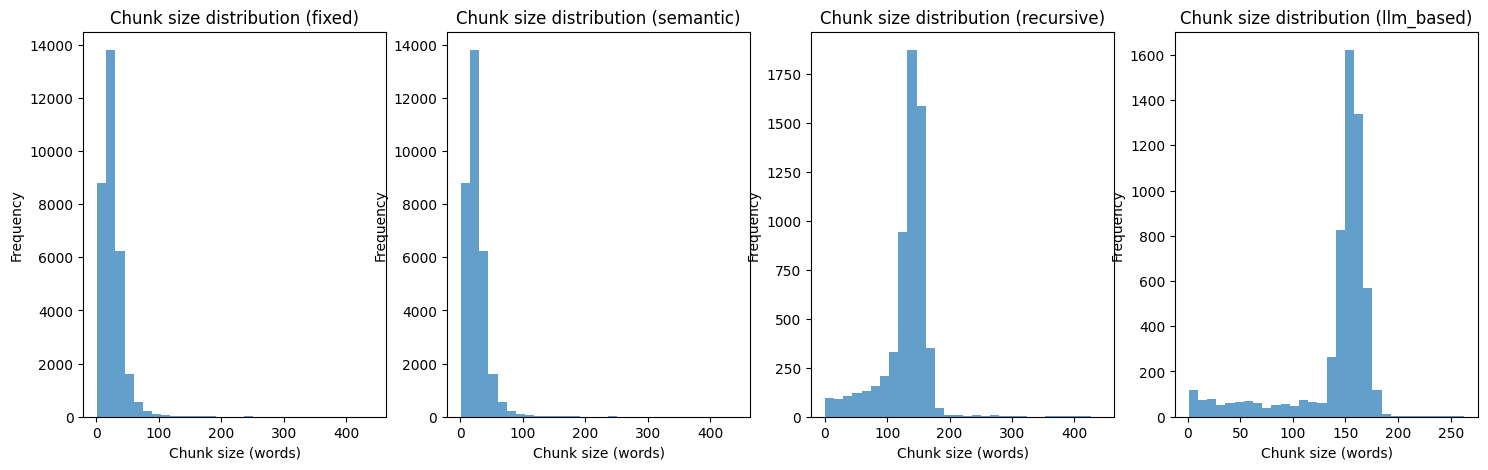

In [29]:
fig,axes = plt.subplots(1,4,figsize=(18,5))
for ax,analysis in zip(axes,analyses) : 
    ax.hist(analysis["sizes"],bins=30,alpha=0.7)
    ax.set_title(f"Chunk size distribution ({analysis['method']})")
    ax.set_xlabel(f"Chunk size ({METRIC})")
    ax.set_ylabel("Frequency")  
